## 1.1 Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import math
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

# import warnings
# warnings.filterwarnings('ignore')

from datetime import timedelta

## 1.2 Import fastf1 Libraries and Set Color Scheme

We will be using the open source fastf1 library for accessing up to date season data

In [2]:
import fastf1 as ff1
from fastf1 import plotting
from fastf1 import utils

# Load FastF1's dark color scheme
ff1.plotting.setup_mpl(mpl_timedelta_support=False, misc_mpl_mods=False,
                          color_scheme='fastf1')

In [3]:
# Enable the cache by providing the name of your cache folder
cache_path = '/Users/charlotte/Desktop/mclaren-performance-analysis-2024/cache'
ff1.Cache.enable_cache(cache_path)

In [4]:
# Define target session
year, grand_prix, session = 2024, 'Miami', 'R'

# Load target session
target_session = ff1.get_session(year, grand_prix, session)
target_session.load(telemetry=True)

# Define target drivers
driver_1, driver_2 = 'NOR', 'VER'
team_1, team_2, team_3 = 'McLaren', 'Ferrari', 'Red Bull Racing'


core           INFO 	Loading data for Miami Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '1', '16', '11', '55', '44', '22', '63', '14', '31', '27', '10', '81', '24', '3', '77', '18', '23', '20', '2']


In [5]:
# Function to lighten team colour
def lighten_color(color, amount=0.5):
    color = mcolors.to_rgb(color)
    return [(1 - amount) * c + amount for c in color]

# Retrieve team colors from target_session.results based on driver abbreviations
team_color_1 = '#' + target_session.results[target_session.results['Abbreviation'] == driver_1].iloc[0]['TeamColor']
team_color_2 = '#' + target_session.results[target_session.results['Abbreviation'] == driver_2].iloc[0]['TeamColor']

# If drivers for analysis are from the same team then adjust driver_2 colour
if team_color_1 == team_color_2:
    # Lighten one color for distinction or use a dashed line
    from matplotlib.colors import to_rgb
    team_color_2 = lighten_color(team_color_2, amount=0.6)
    linestyle_2 = '--'

In [6]:
telemetry = target_session.laps.loc[0].get_car_data().add_distance()
telemetry.head()

,Date,RPM,Speed,nGear,Throttle,Brake,DRS,Source,Time,SessionTime,Distance
0,2024-05-05 20:03:23.810,10082,0,1,15,True,1,car,0 days 00:00:00.014000,0 days 00:55:43.042000,0.000000
1,2024-05-05 20:03:24.170,10221,0,1,15,True,1,car,0 days 00:00:00.374000,0 days 00:55:43.402000,0.000000
2,2024-05-05 20:03:24.530,7981,10,1,15,False,1,car,0 days 00:00:00.734000,0 days 00:55:43.762000,1.000000
3,2024-05-05 20:03:24.810,6021,16,1,16,False,1,car,0 days 00:00:01.014000,0 days 00:55:44.042000,2.244444
4,2024-05-05 20:03:25.169,4264,30,1,27,False,1,car,0 days 00:00:01.373000,0 days 00:55:44.401000,5.236111


In [7]:
# Access selected driver fastest laps
laps_driver_1 = target_session.laps.pick_drivers(driver_1).pick_fastest()
laps_driver_2 = target_session.laps.pick_drivers(driver_2).pick_fastest()

# Retrieve the telemetry and add the distance column
telemetry_driver_1 = laps_driver_1.get_car_data().add_distance()
telemetry_driver_2 = laps_driver_2.get_car_data().add_distance()

In [8]:
# Identify session type analysed for title in more legible way
session_types = {
    'Q': 'Qualifying',
    'R': 'Grand Prix',
    'Practice 1': 'FP1',
    'Practice 2': 'FP2',
    'Practice 3': 'FP3'
}

session_type = session_types.get(session, 'Unknown Session')

In [9]:
# Get the list of races (events) for the season
event_schedule = ff1.get_event_schedule(year)
grand_prix_list = event_schedule['EventName'].tolist()  # List of all race names

In [10]:
# Example dictionary of thresholds based on tracks
track_thresholds = {
    "Monza": {"low_speed": 150, "medium_speed": 220},
    "Monaco": {"low_speed": 80, "medium_speed": 140},
    # Add track thresholds
}


In [11]:
# Function to get the telemetry data for each section
def extract_section_data(telemetry):
    # Define dynamic speed thresholds based on quantiles
    low_speed_threshold = telemetry['Speed'].quantile(0.20)
    medium_speed_threshold = telemetry['Speed'].quantile(0.80)

    # Filter sections
    ls_section = telemetry[telemetry['Speed'] < low_speed_threshold]
    ms_section = telemetry[(telemetry['Speed'] >= low_speed_threshold) & (telemetry['Speed'] < medium_speed_threshold)]
    hs_section = telemetry[telemetry['Speed'] >= medium_speed_threshold]
    
    # Get entry, apex, exit points
    def get_section_points(section):
        if section.empty:
            return None, None, None
        entry = section.iloc[0]
        apex = section[section['Speed'] == section['Speed'].min()].iloc[0]
        exit = section.iloc[-1]
        return entry['Speed'], apex['Speed'], exit['Speed']

    # Extract telemetry points
    ls_entry, ls_apex, ls_exit = get_section_points(ls_section)
    ms_entry, ms_apex, ms_exit = get_section_points(ms_section)
    hs_entry, hs_apex, hs_exit = get_section_points(hs_section)

    # Calculate straight-line speed (SL)
    straight_line_section = telemetry[
        (telemetry['Throttle'] > 0.95) & (telemetry['Brake'] == 0) & (telemetry['nGear'] > 7)
    ]
    straight_line_speed = straight_line_section['Speed'].max() if not straight_line_section.empty else None

    return [straight_line_speed, ls_entry, ls_apex, ls_exit, ms_entry, ms_apex, ms_exit, hs_entry, hs_apex, hs_exit]


In [ ]:
drivers = [driver_1, driver_2]
year = 2024

# Initialise a dictionary to collect data
data = []

# Filter events to include only those that have occurred up to the current date
today = datetime.today()
past_events = event_schedule[event_schedule['EventDate'] <= today]

# Loop through each race and each driver
for idx, row in past_events.iterrows():
    grand_prix = row['EventName']
    print(f">>>> Processing: {grand_prix}")

    # Load the full session to enable telemetry access
    session = ff1.get_session(year, grand_prix, 'R')
    session.load()  # Load full session data

    for driver in drivers:
        print(f'     >>>> Processing: {driver}')
        # Select the fastest lap for the driver
        lap = session.laps.pick_driver(driver).pick_fastest()

        # Load telemetry data only for this fastest lap
        telemetry = lap.get_car_data().add_distance()

        # Extract section data for this lap
        section_data = extract_section_data(telemetry)

        # Append the data for this driver, race, and sections
        data.append([f"{grand_prix} {year}", driver] + section_data)

events      WARNING 	Correcting user input 'Pre-Season Testing' to 'Singapore Grand Prix'
core           INFO 	Loading data for Singapore Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


>>>> Processing: Pre-Season Testing


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '1', '81', '63', '16', '44', '55', '14', '27', '11', '43', '22', '31', '18', '24', '77', '10', '3', '20', '23']
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
core           INFO 	Loading data for Bahrain

     >>>> Processing: NOR
     >>>> Processing: VER
>>>> Processing: Bahrain Grand Prix


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '63', '4', '44', '81', '14', '18', '24', '20', '3', '22', '23', '27', '31', '10', '77', '2']
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
core           INFO 	Loading data for Saudi Ar

     >>>> Processing: NOR
     >>>> Processing: VER
>>>> Processing: Saudi Arabian Grand Prix


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '16', '81', '14', '63', '38', '4', '44', '27', '23', '20', '31', '2', '22', '3', '77', '24', '18', '10']
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
core           INFO 	Loading data for Australi

     >>>> Processing: NOR
     >>>> Processing: VER
>>>> Processing: Australian Grand Prix


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 19 drivers: ['55', '16', '4', '81', '11', '18', '22', '14', '27', '20', '23', '3', '10', '77', '24', '31', '63', '44', '1']
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
core           INFO 	Loading data for Japanese Gran

     >>>> Processing: NOR
     >>>> Processing: VER
>>>> Processing: Japanese Grand Prix


In [ ]:
# Convert data to DataFrame
columns = ["Race", "Driver", "SL", "LS-entry", "LS-apex", "LS-exit",
           "MS-entry", "MS-apex", "MS-exit", "HS-entry", "HS-apex", "HS-exit"]
plot_df = pd.DataFrame(data, columns=columns)

# Separate data for each driver
driver1_data = plot_df[plot_df['Driver'] == driver_1].set_index("Race").drop(columns="Driver")
driver2_data = plot_df[plot_df['Driver'] == driver_2].set_index("Race").drop(columns="Driver")

# Normalize each driver's data
scaler = MinMaxScaler()
driver1_data_normalized = pd.DataFrame(scaler.fit_transform(driver1_data), columns=driver1_data.columns, index=driver1_data.index)
driver2_data_normalized = pd.DataFrame(scaler.fit_transform(driver2_data), columns=driver2_data.columns, index=driver2_data.index)

# Invert driver2's data to negative
driver2_data_normalized = -driver2_data_normalized

# Combine data by taking the sum (dominance shown as positive for driver 1, negative for driver 2)
combined_data = driver1_data_normalized + driver2_data_normalized

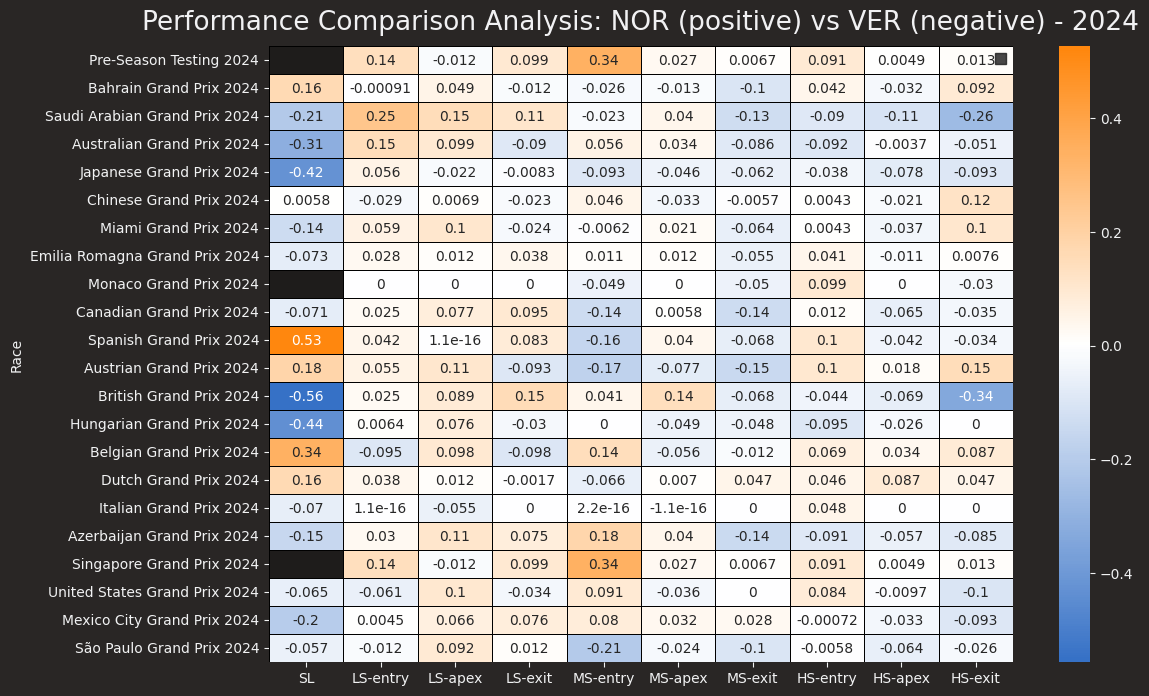

In [ ]:
# Create a custom color map using the team colors
cmap = LinearSegmentedColormap.from_list("team_colors", [team_color_2, "white", team_color_1])

# Plot the combined heatmap with team colors
plt.figure(figsize=(12, 8))
sns.heatmap(combined_data, cmap=cmap, center=0, annot=True, linewidths=0.5, linecolor="black")
plt.title(f"Performance Comparison Analysis: {driver_1} (positive) vs {driver_2} (negative) - {year}")

# Add a reference key for team colors
plt.legend([driver_1,driver_2])

plt.show()